# Titanic: Machine Learning from Disaster

## Introduction
The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Problem Statement 
In this challenge, we are tasked to complete the analysis of what kinds of people were likely to survive. 

## Approach
Using data visualization techniques, we identify relationships between various feature in the dataset. In addition, we create new features which are good indicators of whether a passenger survived the tragedy. Next, we impute missing data based on these features (i.e. the conditional mean), using a split-apply-combine strategy. Following which, we use a correlation plot to determine important features which are correlated with whether a passenger survived.

After the data is cleaned, the new features are created and the features are selected, we segregate the training dataset into a sub-training and sub-testing dataset. Following which, we employ various machine learning algorithms (such as Random Forest and Gradient Boosting) with hyperparameter turning and cross-validation to find the best model (using the subtesting score) at predicting whether a passenger survived given his/her features across all the models.

We found that the Random Forest model with 1000 trees performed the best on the cross-validation datasets. In addition, it generalized pretty well to the testing dataset. As such, we used the Random Forest model to predict for the testing dataset.

## Evaluation
Following [Kaggle's evaluation method](https://www.kaggle.com/c/titanic#evaluation), we will use the accuracy metric to evaluate our models.

## Afternote
Our model achieved a score of 0.80383. This was a huge improvement from my previous score, and places us at the top 15 percentile of the competition.

**Note**
*  I cannot stress the importance of the [Pytanic Kernel](https://www.kaggle.com/headsortails/pytanic). The kernel has helped me to formulate and develop various hypotheses, identify and create key features which are correlated with our test label (whether a particular passenger survived the Titanic Tragedy). Please check Heads or Tails' kernel out; you won't regret it!

### Importing key libraries and reading dataframes

As usual, we begin by importing key libraries, and read the dataframes.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
combined = pd.concat([df_train, df_test])

### Exploratory Data Analysis and Feature Creation

First, we check the structure of the dataframe. How does the dataframe look like?

In [4]:
combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [5]:
combined.apply(set)

Age            {nan, nan, 2.0, 3.0, 4.0, 5.0, nan, 7.0, 8.0, ...
Cabin          {nan, C78, E60, D17, F E46, D50, E77, C30, D56...
Embarked                                          {Q, nan, S, C}
Fare           {7.25, 29.125, 93.5, 7.8792, 5.0, 73.5, 227.52...
Name           {Mellors, Mr. William John, Thomas, Mr. John, ...
Parch                                   {0, 1, 2, 3, 4, 5, 6, 9}
PassengerId    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
Pclass                                                 {1, 2, 3}
Sex                                               {male, female}
SibSp                                      {0, 1, 2, 3, 4, 5, 8}
Survived       {0.0, 1.0, nan, nan, nan, nan, nan, nan, nan, ...
Ticket         {367226, 330844, SOTON/OQ 392090, C.A. 29566, ...
dtype: object

First, we note that there are NA values in the dataframe. We may have to create a strategy to impute the missing data.

In addition, we also note that the column, Name, does not appear to be informative. Can we give meaning to the column by creating new features using this feature? As it turns out, we are able to use the Name column to create 2 new columns - the First Name of the person and his/her Title.

In [6]:
def first_name(x): 
    return x.split(', ')[0]

combined['FirstName'] = combined['Name'].apply(first_name)

In [7]:
def title(x):
    return x.split(', ')[1].split('.')[0]

combined['Title'] = combined['Name'].apply(title)

In [8]:
combined.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FirstName,Title
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,Braund,Mr
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,Cumings,Mrs
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Miss
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,Futrelle,Mrs
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,Allen,Mr


Next, we take a quick look at the unique values, as well as the counts of the values, that the feature Title can take on.

In [9]:
print combined['Title'].value_counts()
print len(set(combined['Title']))

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Mme               1
the Countess      1
Don               1
Lady              1
Sir               1
Jonkheer          1
Dona              1
Capt              1
Name: Title, dtype: int64
18


We note that there a total of 18 unique titles in the Title column (in both the training and the test set). That's a tad too many. It appears that there are some 'misclassified' obseravtions; Ms, Mme and Mlle ought to be classified as Miss. From our observation, 4 titles dominate the distribution - Mr, Miss, Mrs and Master. We create a new category to sort the other Titles.

In [10]:
def unique_title(x):
    if x in ('Mr', 'Miss', 'Mrs', 'Master'): return x
    if x in ('Ms', 'Mlle', 'Mme'): return 'Miss'
    else: return 'Others'
    
combined['Title'] = combined['Title'].apply(unique_title)

After sorting the Title column, let's take a quick look at the age distribution of the dataset.

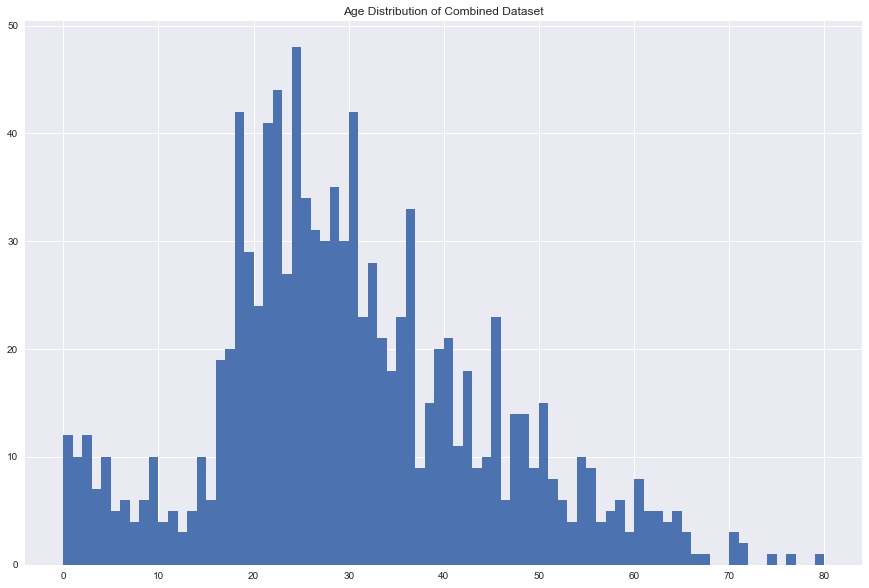

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 1, 1)
plt.hist(combined['Age'].dropna(), bins=range(0, 81, 1))
plt.title('Age Distribution of Combined Dataset')
plt.show()

Judging from the Age distribution of the dataset, it appears that there were many young and middle-aged persons on the Titanic. Nothing really seems to stand out, apart from the fact that there were quite a few elderly people on board.

Who is likely to survive based on their age alone?

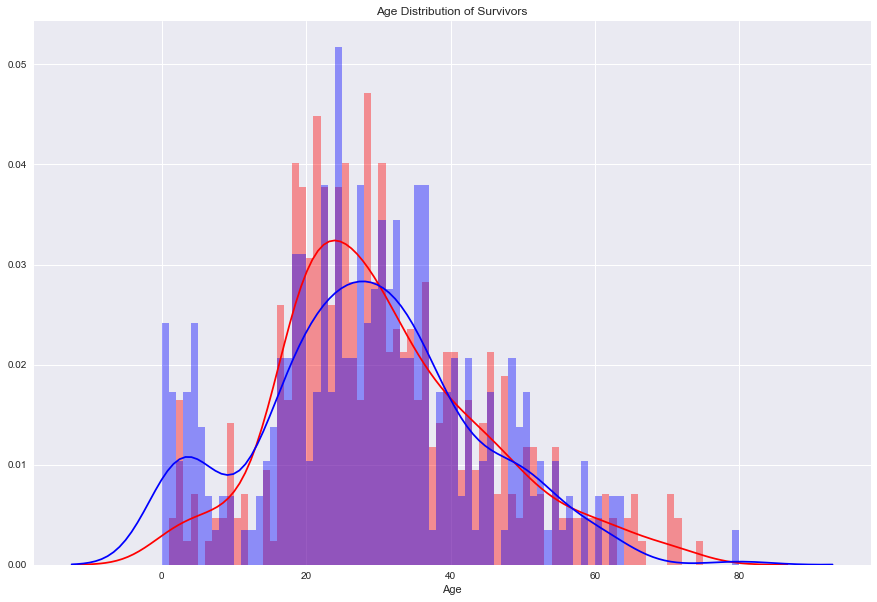

In [12]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 1, 1)
sns.distplot(combined[combined.Survived == 0].Age.dropna(), bins=range(0, 81, 1), color = 'red')
sns.distplot(combined[combined.Survived == 1].Age.dropna(), bins=range(0, 81, 1), color = 'blue')
plt.title('Age Distribution of Survivors')
plt.show()

As it turns out, children under the age of 10 are typically more likely to survive than perish. For all other age groups, the trend is reversed; people are more likely to perish than survive. Let's create a feature to capture this trend.

In [13]:
combined['Child'] = (combined['Age'] <= 10)

We now turn our attention to the Ticket type.

In [14]:
print 'Total Unique Values for Ticket: ', len(set(combined['Ticket']))
print 'Length of Combined Dataset: ', len(combined)

Total Unique Values for Ticket:  929
Length of Combined Dataset:  1309


Similarly, the Ticket feature does not appear to be terribly informative as well. Let's take a quick look at the unique values in the column. There are 929 unique values out of a total 1309 values, suggesting that some of the tickets might be held by more than 1 person. What's the distribution of shared tickets? Let's find out.

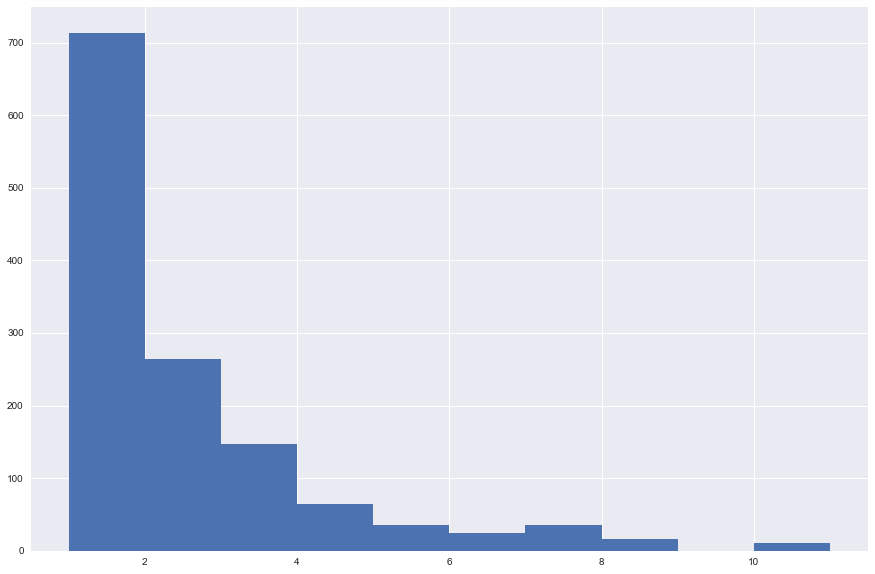

In [15]:
shared_tickets = combined.groupby('Ticket')['Name'].transform('count')

plt.figure(figsize=(15, 10))
plt.hist(shared_tickets.values)
plt.show()

combined['SharedTickets'] = shared_tickets.values

As it turns out, many of the ticket holders travel alone. There are also large groups (8 or more people travelling together). Are solo travellers more likely to survive? Let's take a look.

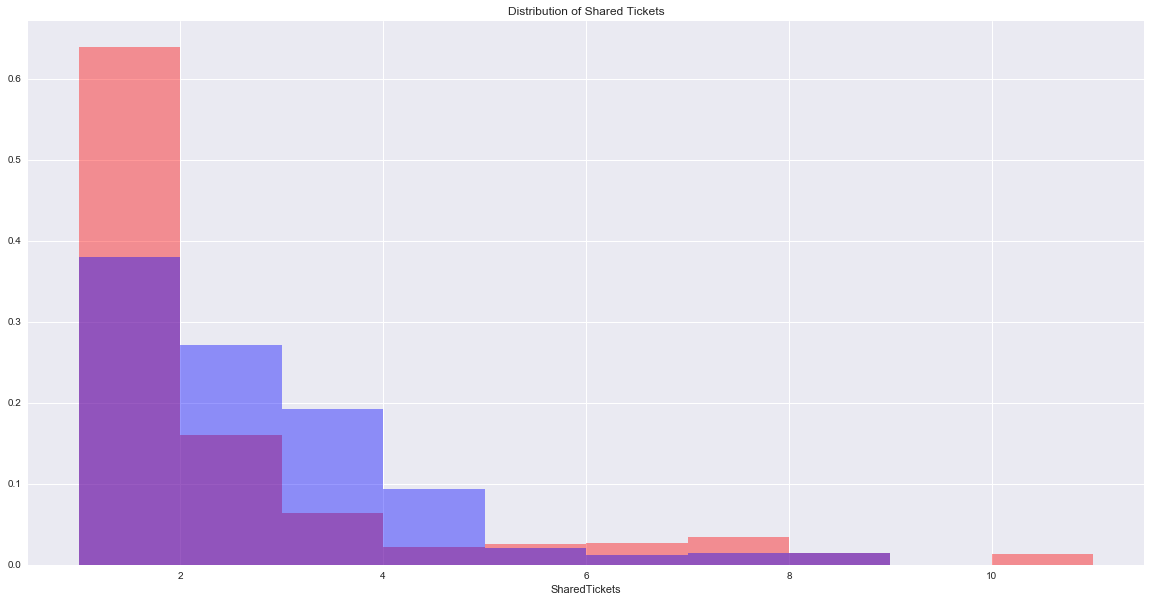

In [16]:
plt.figure(figsize=(20, 10))

sns.distplot(combined[(combined.Survived == 0)].SharedTickets.dropna(),
             bins = range(1, 12, 1), kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[(combined.Survived == 1)].SharedTickets.dropna(),
             bins = range(1, 12, 1), kde = False, norm_hist = True, color = 'blue')
plt.title('Distribution of Shared Tickets')

As it turns out, individuals with shared tickets (i.e. SharedTickets > 1) have a much higher likelihood of surviving. We proceed to convert this feature into a binary variable. However, this relationship does not hold true for all travellers. In particular, we note that this phenomena holds true for individuals who are sharing their tickets with 1 to 3 **other** passengers.

In [17]:
def shared_tickets(x): 
    if x > 1: return(0)
    else: return(1)

def good_shared_tickets(x):
    if x > 1 and x < 5: return(1)
    else: return(0)

combined['GoodSharedTickets'] = combined['SharedTickets'].apply(good_shared_tickets)
combined['Alone'] = combined['SharedTickets'].apply(shared_tickets)

Lastly, to clean up the Ticket Column, we rely on the same strategy that [Heads or Tails](https://www.kaggle.com/headsortails/pytanic) used; that is, we looked at the first character of the string to differentiate different types of tickets.

In [18]:
combined['TicketType'] = combined['Ticket'].apply(lambda(x): x[0])

print 'Unique Ticket Values: ', len(set(combined['Ticket']))
print 'Unique Ticket Values (First Character): ', len(set(combined['TicketType']))

Unique Ticket Values:  929
Unique Ticket Values (First Character):  16


Using the first character of the ticket, we managed to reduce the ticket column from 929 unique values to 16.

Are there any missing values in the dataset? We can use the function ``` df.isnull().sum() ``` to find out.

In [19]:
combined.isnull().sum()

Age                   263
Cabin                1014
Embarked                2
Fare                    1
Name                    0
Parch                   0
PassengerId             0
Pclass                  0
Sex                     0
SibSp                   0
Survived              418
Ticket                  0
FirstName               0
Title                   0
Child                   0
SharedTickets           0
GoodSharedTickets       0
Alone                   0
TicketType              0
dtype: int64

We note that there are missing values in the Age, Cabin, Embarked, Fare and Survived (not suprisingly at all, since the Survived variable is the variable we are trying to predict in the first place) columns. In particular, there are 263 missing Age values and 1014 missing Cabin values. Let's take a quick look at the unique values that the Cabin feature can take on.

There appears to be missing values in the Age, Fare, Cabin and Embarked features. In particular, the Cabin feature seems to be missing many values. Let's take a quick look at the unique values that the Cabin feature could take on.

In [20]:
print len(set(combined['Cabin']))

187


In [21]:
print combined['Cabin'].value_counts()[0:5]

C23 C25 C27        6
B57 B59 B63 B66    5
G6                 5
D                  4
B96 B98            4
Name: Cabin, dtype: int64


Looking at 5 unique values of the Cabin feature, 2 things stand out:

1. The cabins typically start with an alphabet. The alphabet may be an indicator of where the cabin is located at (the Deck location), or it could simply imply the class of the cabin e.g. cabins that start with the letter A is better.

2. There are several observations with more than 1 cabin. Typically, shared cabins have more than 1 person staying in them/

3. The large amount of missing values in the Cabin feature could be due to the fact that only the Survivors (which lived to tell the tale) reported their Cabin numbers.

With this knowledge, we could create 2 new features from the Cabin variable. The first feature we create would be a binary variable - it takes on the value 1 if the individual has a Cabin, and 0 otherwise. Our second feature returns the type of cabin that the individual is staying in. Let's bear this in mind for later.

In [22]:
def cabintostay(x):
    if pd.isnull(x): return(0)
    else: return(1)

combined['CabinToStay'] = combined['Cabin'].apply(cabintostay)

In [23]:
def cabinclass(x):
    if pd.isnull(x): return('N')
    else: return (x.split())[0][0]

combined['CabinClass'] = combined['Cabin'].apply(cabinclass)

Let's take a quick look at the summary of our dataset.

In [24]:
combined.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived,SharedTickets,GoodSharedTickets,Alone,CabinToStay
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838,2.101604,0.362872,0.544691,0.225363
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592,1.779832,0.481012,0.498189,0.417981
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000,11.000000,1.000000,1.000000,1.000000


Are individuals with more Siblings/Spouses or Parents/Children more likely to survive? We can plot this using a violin plot.

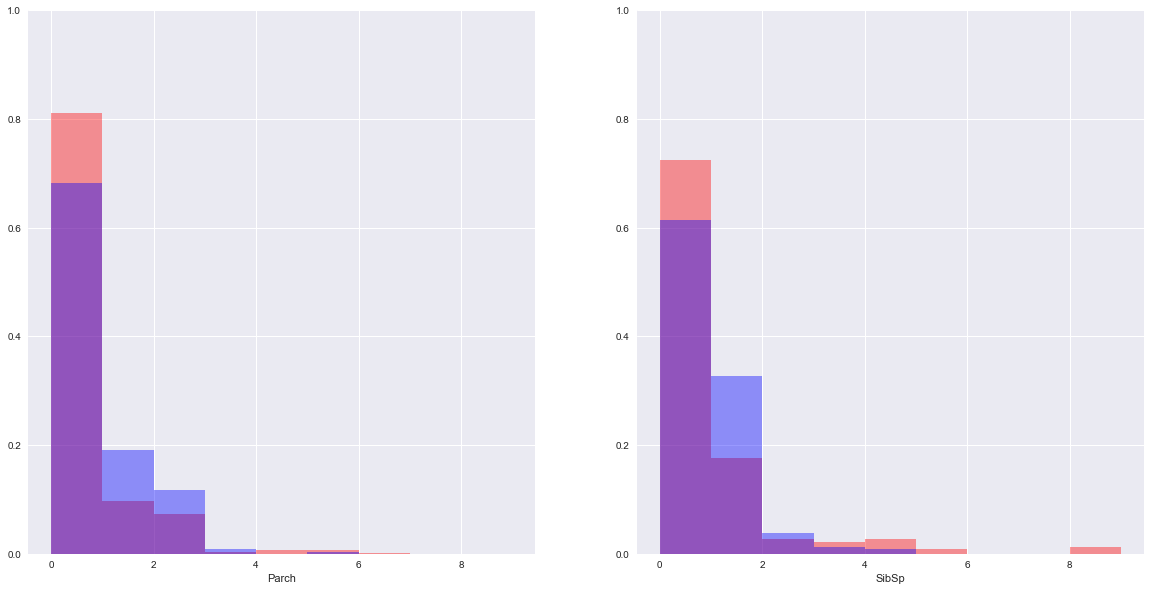

In [25]:
plt.figure(figsize=(20,10))

plt.subplot(121)
sns.distplot(combined[combined.Survived == 0].Parch.dropna(), bins=range(0, 10, 1), 
             kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[combined.Survived == 1].Parch.dropna(), bins=range(0, 10, 1), 
             kde = False, norm_hist = True, color = 'blue')
plt.ylim([0, 1])

plt.subplot(122)
sns.distplot(combined[combined.Survived == 0].SibSp.dropna(), bins=range(0, 10, 1), 
             kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[combined.Survived == 1].SibSp.dropna(), bins=range(0, 10, 1), 
             kde = False, norm_hist = True, color = 'blue')
plt.ylim([0, 1])
plt.show()

In [26]:
combined['Family'] = combined['Parch'] + combined['SibSp']

In [27]:
set(combined.Family)

{0, 1, 2, 3, 4, 5, 6, 7, 10}

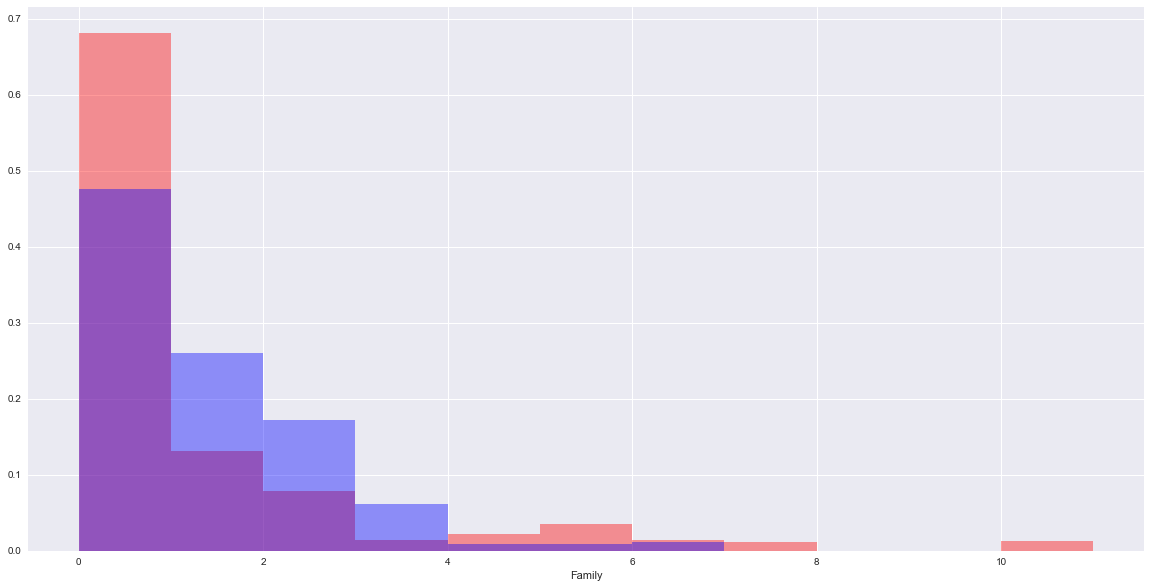

In [28]:
plt.figure(figsize=(20,10))

sns.distplot(combined[combined.Survived == 0].Family.dropna(), bins=range(0, 12, 1), 
             kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[combined.Survived == 1].Family.dropna(), bins=range(0, 12, 1), 
             kde = False, norm_hist = True, color = 'blue')

As it turns out, families that are large, but not **that** large are more likely to survive the tragedy.

In [29]:
combined['MiddleFam'] = ((combined['Family'] > 0) & (combined['Family'] < 4))

Next, we turn to the question: does the area of embarkment or the fare you pay determine whether you survive?

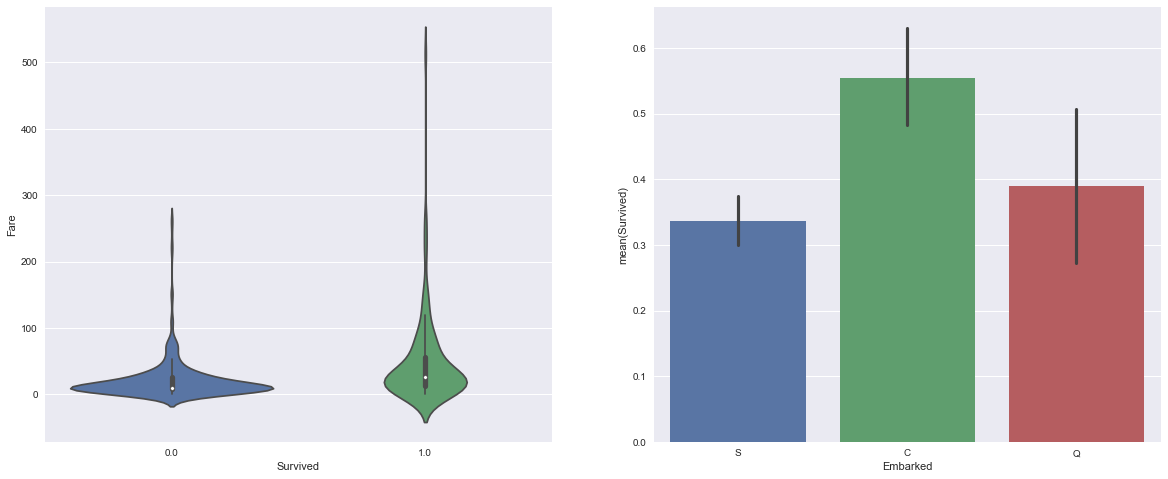

In [30]:
plt.figure(figsize=(20,8))

plt.subplot(1, 2, 1)
sns.violinplot('Survived', 'Fare', data = combined)

plt.subplot(1, 2, 2)
sns.barplot('Embarked', 'Survived', data = combined)

From our simple plots, it does appear that those that pay higher fares are more likely to survive, although I believe that isn't **statistically significant**. In addition, we note that embarking at 'C' results in higher likelihood of surviving the tragedy. Also, we note that the lower bound of the 95% confidence interval around 'C' does not include 40%, indicating that embarkment point 'C' is indeed a potentially powerful predictor of survival, and is statistically significant.

Before we jump to conclusions, we have to understand that there might be confounding factors at play. For example, if more females than males boarded at 'C', and females were more likely to survive the tragedy, this implies that the place of embarkment does not play a significant role in predicting whether a particular passenger survived the tragedy. As good data scientists, we have to bear these nuances in mind when conducting analyses.

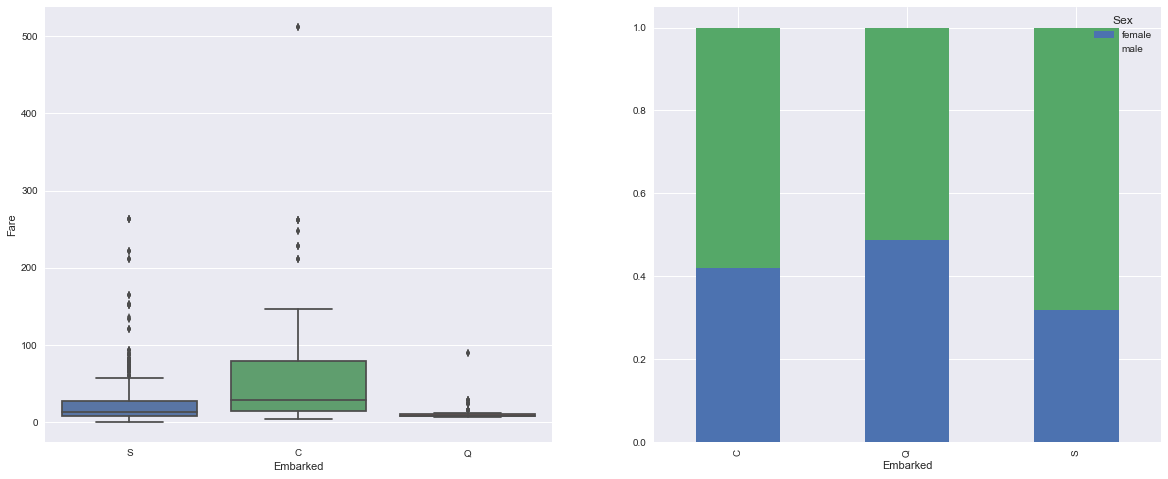

In [31]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

sns.boxplot('Embarked', 'Fare', data = combined, ax = ax1)

tab1 = pd.crosstab(combined['Embarked'], combined['Sex'])
plot1 = tab1.div(tab1.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax2)

plt.show()

As it turns out, passengers who embarked at 'C' tended to pay higher fares. However, there does not appear to be any other significant confounding factors at play.

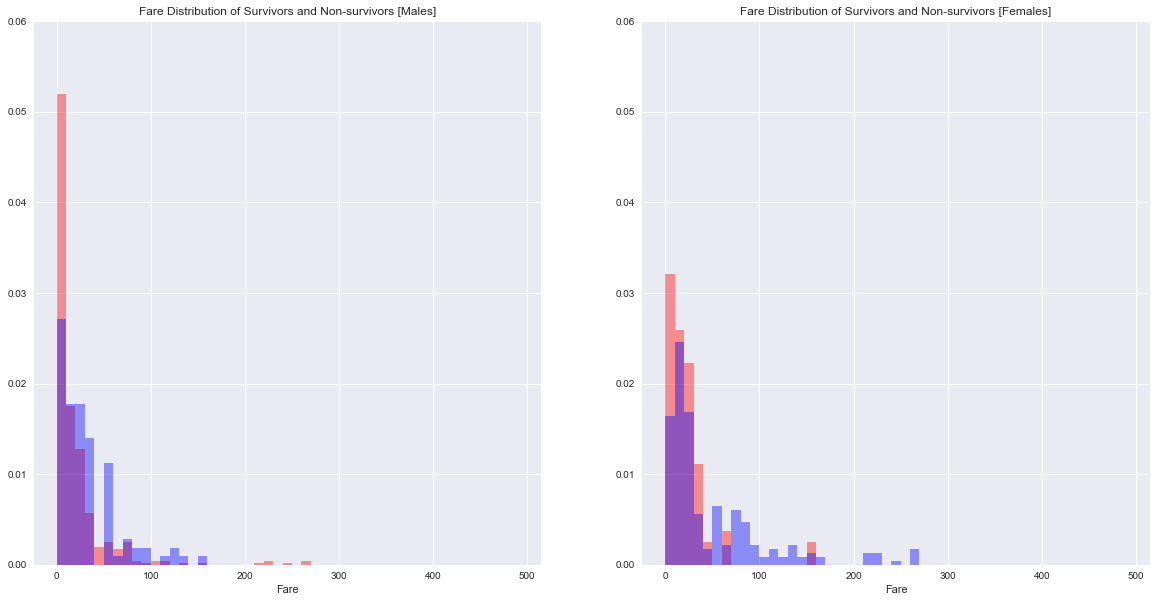

(21.960992948717951, 40.821484403669722)
(23.024385185185185, 51.938573390557941)


In [32]:
plt.figure(figsize=(20,10))

plt.subplot(121)
sns.distplot(combined[(combined.Survived == 0) & (combined.Sex == 'male')].Fare.dropna(), 
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[(combined.Survived == 1) & (combined.Sex == 'male')].Fare.dropna(), 
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'blue')
plt.ylim([0, 0.06])
plt.title('Fare Distribution of Survivors and Non-survivors [Males]')

plt.subplot(122)
sns.distplot(combined[(combined.Survived == 0) & (combined.Sex == 'female')].Fare.dropna(), 
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[(combined.Survived == 1) & (combined.Sex == 'female')].Fare.dropna(), 
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'blue')
plt.ylim([0, 0.06])
plt.title('Fare Distribution of Survivors and Non-survivors [Females]')

plt.show()

print ((combined[(combined.Survived == 0) & (combined.Sex == 'male')].Fare.mean()), 
       (combined[(combined.Survived == 1) & (combined.Sex == 'male')].Fare.mean()))
print ((combined[(combined.Survived == 0) & (combined.Sex == 'female')].Fare.mean()), 
       (combined[(combined.Survived == 1) & (combined.Sex == 'female')].Fare.mean()))

As it turns out, Survivors tend to pay a higher price (no pun intended) for their fares. However, we do note that the probability of survival increases with the fare you pay, no matter which gender you are. However, the effects are asymmetric. For individuals who paid less than 10 dollars for their ticket, males are much more likely to die than females. The effect becomes more nuanced after.

One side note though: for males who paid more than 200 dollars, it turns out that most of them died, whereas the females who paid the same amount survived.

Hang on - something smells fishy: People who pay more for their ticket typically should have a higher probability of survival! Unless... they are older. 

This begs the question: Do older people, in particular, older males, pay more than their counterparts? That is, do we expect to see a negative relationship between Age and Fare?

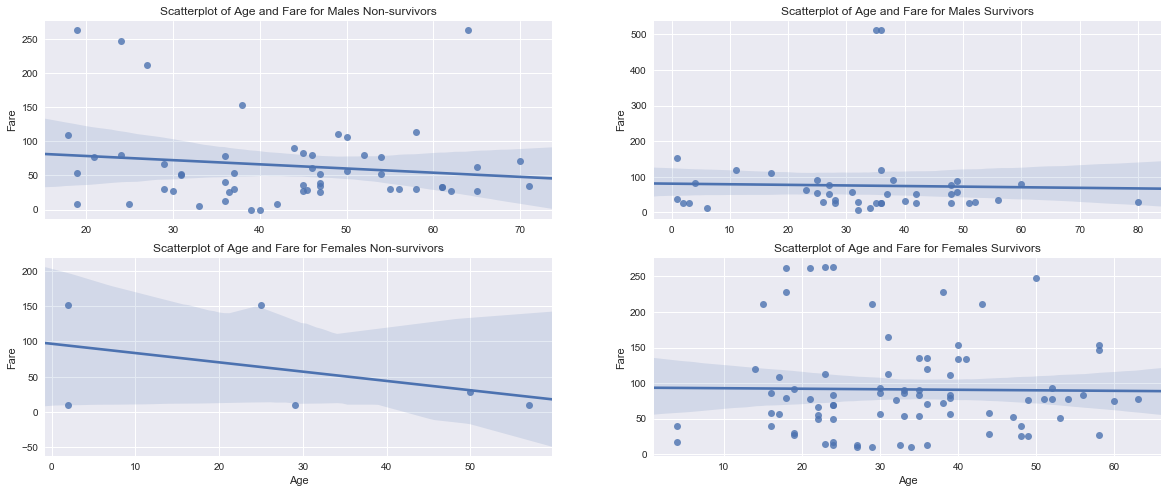

In [33]:
plt.figure(figsize=(20,8))

plt.subplot(221)
sns.regplot(combined[(combined.Survived == 0) & (combined.Sex == 'male')].dropna()['Age'],
            combined[(combined.Survived == 0) & (combined.Sex == 'male')].dropna()['Fare'])
plt.xlabel('')
plt.title('Scatterplot of Age and Fare for Males Non-survivors')

plt.subplot(222)
sns.regplot(combined[(combined.Survived == 1) & (combined.Sex == 'male')].dropna()['Age'],
            combined[(combined.Survived == 1) & (combined.Sex == 'male')].dropna()['Fare'])
plt.xlabel('')
plt.title('Scatterplot of Age and Fare for Males Survivors')

plt.subplot(223)
sns.regplot(combined[(combined.Survived == 0) & (combined.Sex == 'female')].dropna()['Age'],
            combined[(combined.Survived == 0) & (combined.Sex == 'female')].dropna()['Fare'])
plt.title('Scatterplot of Age and Fare for Females Non-survivors')

plt.subplot(224)
sns.regplot(combined[(combined.Survived == 1) & (combined.Sex == 'female')].dropna()['Age'],
            combined[(combined.Survived == 1) & (combined.Sex == 'female')].dropna()['Fare'])
plt.title('Scatterplot of Age and Fare for Females Survivors')

plt.show()

There does not appear to be a **statistically significant** relationship between Age and Fare. We observe that the older the individual, the less he/she spends on his ticket. Overall, the effect is weak, and we probably shouldn't read too much into it. Perhaps the trend is just an outlier. After all, there are only 6 values anyway, and we cant really tell whether it is a trend or a blip.

We observe that some tickets cost more than $500. Let's investigate this trend in more detail.

In [34]:
sum(combined[(combined.Survived == 0) & (combined.Sex == 'male')].Fare.dropna() > 200)

6

In [35]:
print 'Number of Tickets costing more than $500: ', sum(combined.Fare.dropna() > 500)

combined[combined.Fare > 500] # What are the 4 rows?

Number of Tickets costing more than $500:  4


,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Title,Child,SharedTickets,GoodSharedTickets,Alone,TicketType,CabinToStay,CabinClass,Family,MiddleFam
258,35.0,NaN,C,512.3292,"Ward, Miss. Anna",0,259,1,female,0,...,Miss,False,4,1,0,P,0,N,0,False
679,36.0,B51 B53 B55,C,512.3292,"Cardeza, Mr. Thomas Drake Martinez",1,680,1,male,0,...,Mr,False,4,1,0,P,1,B,1,True
737,35.0,B101,C,512.3292,"Lesurer, Mr. Gustave J",0,738,1,male,0,...,Mr,False,4,1,0,P,1,B,0,False
343,58.0,B51 B53 B55,C,512.3292,"Cardeza, Mrs. James Warburton Martinez (Charlo...",1,1235,1,female,0,...,Mrs,False,4,1,0,P,1,B,1,True


Looking closely at the 4 rows, something stands out. The passengers were all sharing tickets - PC17755. Also, we note that 3 out of the 4 individuals survived. We have previously identified that individuals that share tickets are more likely to die or survive together. However, it is entirely plausible that:
* For individuals that share tickets, the fare prices was not adjusted for the number of members sharing the ticket.

To test this hypothesis, we focus on obtaining the fare distribution of individuals which have shared tickets, and compare them to those which have not. If it turns out that the fare distributions are systematically different, then our hypothesis is right.

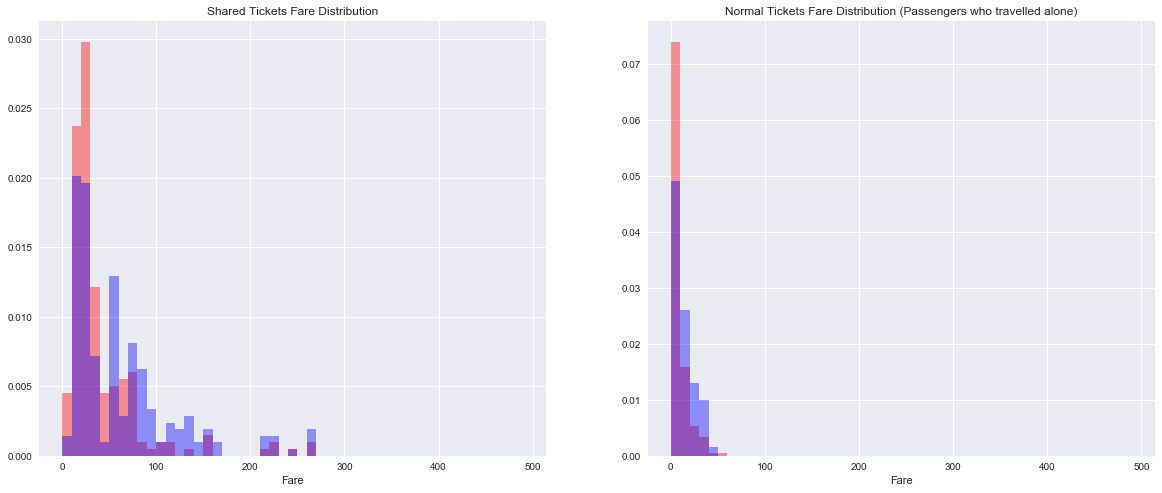

In [36]:
plt.figure(figsize=(20,8))

plt.subplot(121)
sns.distplot(combined[(combined.Alone == 0) & (combined.Survived == 0)].Fare.dropna(),
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[(combined.Alone == 0) & (combined.Survived == 1)].Fare.dropna(),
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'blue')
plt.title('Shared Tickets Fare Distribution')

plt.subplot(122)
sns.distplot(combined[(combined.Alone == 1) & (combined.Survived == 0)].Fare.dropna(),
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[(combined.Alone == 1) & (combined.Survived == 1)].Fare.dropna(),
             bins=range(0, 500, 10),  kde = False, norm_hist = True, color = 'blue')
plt.title('Normal Tickets Fare Distribution (Passengers who travelled alone)')

As it turns out, the fare should be normalized.

In [37]:
shared_tickets = combined.groupby('Ticket')['Name'].transform('count')
combined['AdjustedFare'] = combined['Fare'] / shared_tickets

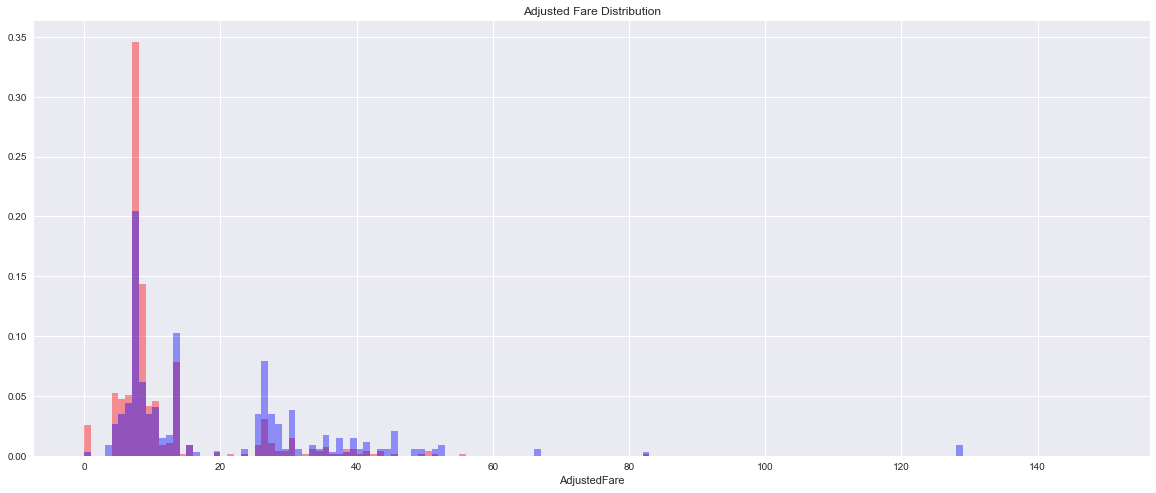

In [38]:
plt.figure(figsize=(20,8))
sns.distplot(combined[(combined.Survived == 0)].AdjustedFare.dropna(),
             bins=range(0, 150, 1), kde = False, norm_hist = True, color = 'red')
sns.distplot(combined[(combined.Survived == 1)].AdjustedFare.dropna(),
             bins=range(0, 150, 1), kde = False, norm_hist = True, color = 'blue')
plt.title('Adjusted Fare Distribution')

Following our adjustment, the relationship between fares and survival appears to be much more convincing now. We note that for fares which are between 0 - 10, the probability of perishing is greater than the probability of surviving. Similar to [Heads or Tails](https://www.kaggle.com/headsortails/pytanic), we use the threshold of 10 to discern between pricey and cheap tickets.

As there are zeroes in the dataset (17 to be exact), we add 1 to the base.

In [39]:
combined['CheapTickets'] = combined['AdjustedFare'] <= 10

In [40]:
pd.crosstab(combined['CheapTickets'], combined['Survived'])

Survived,0.0,1.0
CheapTickets,,
False,160,199
True,389,143


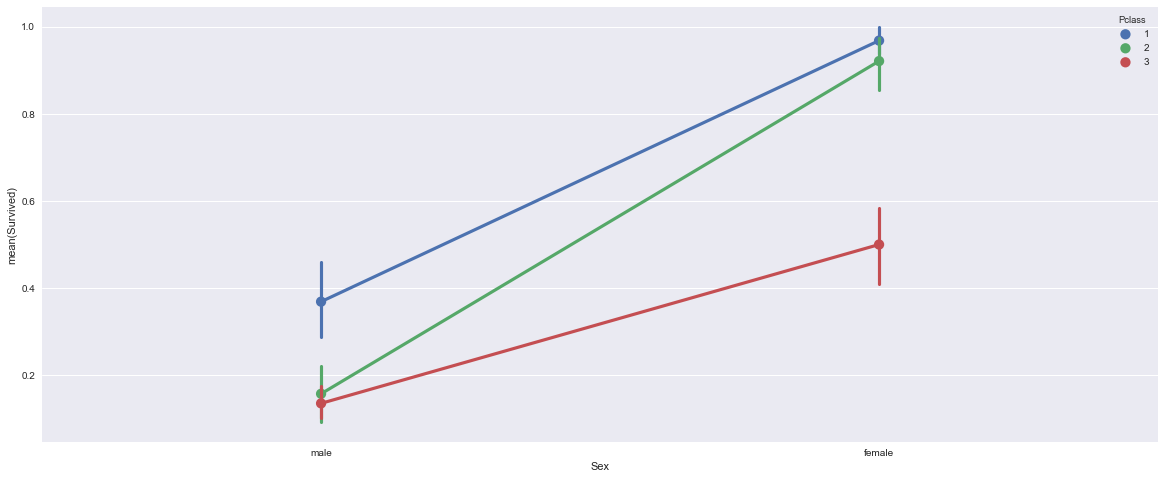

In [41]:
plt.figure(figsize=(20,8))
sns.pointplot('Sex', 'Survived', hue = 'Pclass', data = combined)

The likelihood of a Female surviving is higher than that of a comparable male across all classes. However, the 'survival premium' associated with being a Female is asymmetric; it is different across different classes. The slopes of the different lines represent the 'survival premium' associated with being Female.

It appears that the 'survival premium' is the greatest for Class 2 passengers i.e. Class 2 passenger females have the highest 'survival premium'.

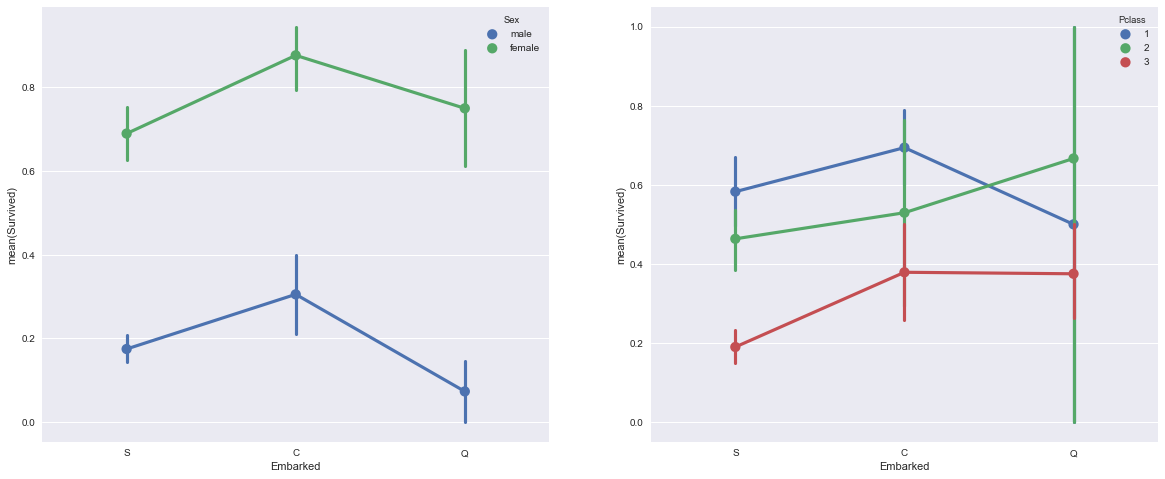

In [42]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

p = sns.factorplot('Embarked', 'Survived', hue = 'Sex', data = combined, ax = ax1)
plt.close(p.fig)

g = sns.factorplot('Embarked', 'Survived', hue = 'Pclass', data = combined, ax = ax2)
plt.close(g.fig)

Does the 'survival premium' change across different embarkment points? It doesn't seem to be the case. From the first plot, we observe that females stand a larger chance of surviving across all embarkment points. In addition, we note that individuals that board at 'C' stands the largest chance of surviving the tragedy, while individuals which boarded Titanic at 'Q' stands the lowest chance (albeit significant uncertainty, perhaps due to the small observations).

Was the difference in survival probability across the different embarkment point due to the survival probability of each individual passenger class? It does not appear to be the case. From the second plot, we observe that there isn't any significant difference between survival probability across the 3 classes controlled for embarkment point (save for port 'C'). 

This suggests that the gender and passenger class composition of the passengers across the different embarkment points are the main drivers for the difference in the survival probability of different embarkment points.

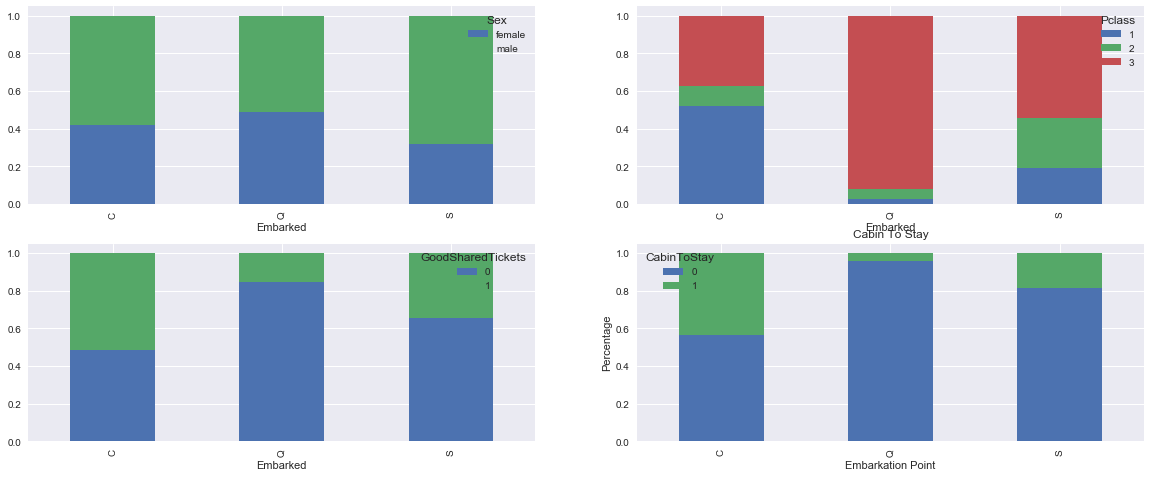

In [43]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223); ax4 = fig.add_subplot(224)

tab1 = pd.crosstab(combined['Embarked'], combined['Sex'])
plot1 = tab1.div(tab1.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax1)
plot1 = plt.xlabel('Embarkation Point')
plot1 = plt.ylabel('Percentage')
plot1 = plt.title('Sex')

tab2 = pd.crosstab(combined['Embarked'], combined['Pclass'])
plot2 = tab2.div(tab2.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax2)
plot2 = plt.xlabel('Embarkation Point')
plot2 = plt.ylabel('Percentage')
plot2 = plt.title('Pclass')

tab3 = pd.crosstab(combined['Embarked'], combined['GoodSharedTickets'])
plot3 = tab3.div(tab3.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax3)
plot3 = plt.xlabel('Embarkation Point')
plot3 = plt.ylabel('Percentage')
plot3 = plt.title('Good Shared Tickets')

tab4 = pd.crosstab(combined['Embarked'], combined['CabinToStay'])
plot4 = tab4.div(tab3.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax4)
plot4 = plt.xlabel('Embarkation Point')
plot4 = plt.ylabel('Percentage')
plot4 = plt.title('Cabin To Stay')

It turns out that we were (partially) right. Compared to other embarkation points, 'C' has the largest percentage of Class 1 passengers. At the same time, most passengers which embarked at 'C' had cabins to stay in. However, we note that although 'Q' has a relatively large proportion of female passengers, it has the lowest survival probability out of the 3 embarkation points. This might be attributed to its huge proportion of Class 3 passengers.

This means that the embarkation point may not be a good predictor of whether an individual survived the tragedy, as it is correlated with the Pclass and Sex features.

Finally, we ask whether the Cabin features are good predictors of whether a person has survived the tragedy. First, we check whether the Cabin features are correlated with Passenger Class and Fares. Intuitively, we expect tickets with cabins assigned should cost more.

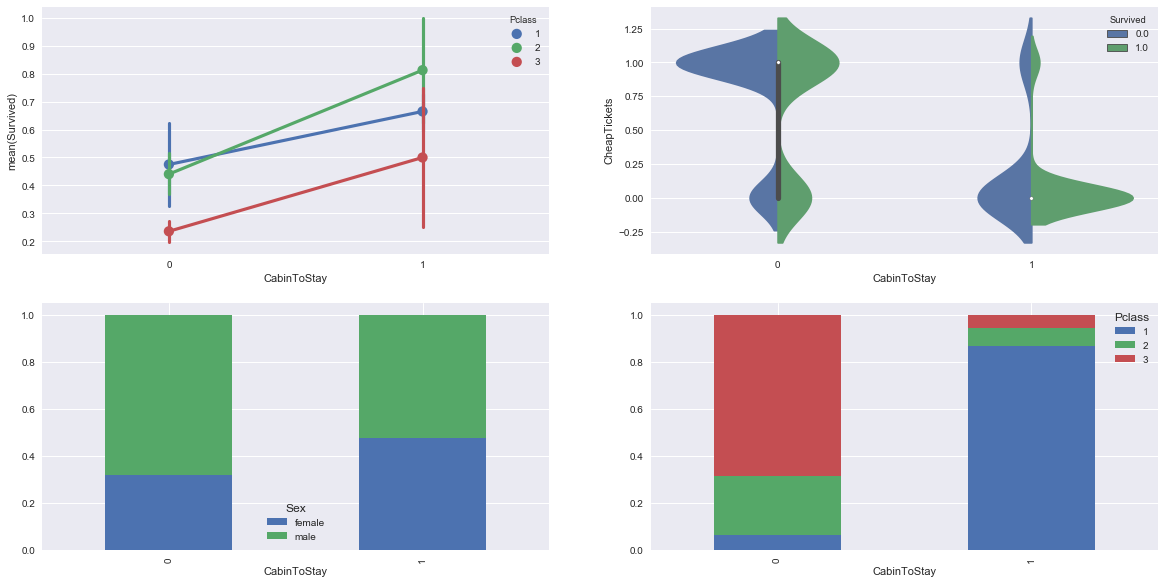

In [44]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223); ax4 = fig.add_subplot(224)

g1 = sns.factorplot('CabinToStay', 'Survived', hue = 'Pclass', data = combined, ax = ax1)
plt.close(g1.fig)
sns.violinplot('CabinToStay', 'CheapTickets', hue = 'Survived', 
               data = combined, ax = ax2, split = True)

tab1 = pd.crosstab(combined['CabinToStay'].dropna(), 
                   combined[pd.notnull(combined.CabinToStay)].Sex)
tab1.div(tab1.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax3)

tab2 = pd.crosstab(combined['CabinToStay'].dropna(), 
                   combined[pd.notnull(combined.CabinToStay)].Pclass)
tab2.div(tab2.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax4)

It appears that the high probability of survival for passengers who stayed in a cabin could be attributed to their passenger class, and their gender. Passengers who were staying in cabins were more likely to survive precisely because females and rich passengers were more likely to survive the tragedy.

Finally, we turn to Ticket Types and Cabin Classes. Which ticket types or cabin classes are likely to result in higher survival probabilities?

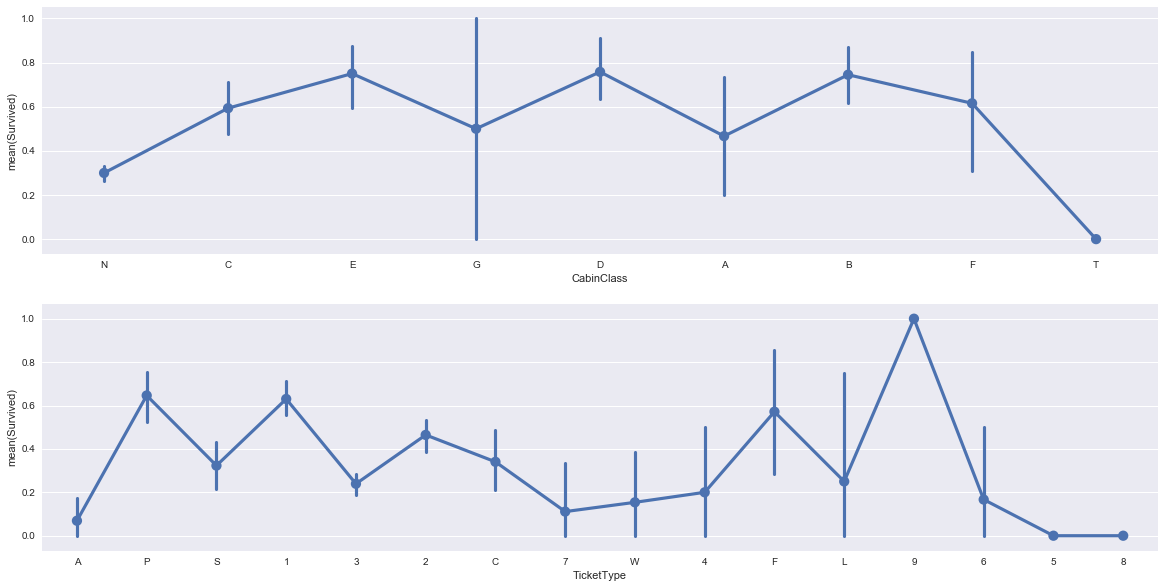

In [45]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(211); ax2 = fig.add_subplot(212)

g1 = sns.factorplot('CabinClass', 'Survived', data = combined, ax = ax1)
plt.close(g1.fig)
g2 = sns.factorplot('TicketType', 'Survived', data = combined, ax = ax2)
plt.close(g2.fig)

From the factor plots, we observe that certain CabinClasses and TicketTypes are associated with higher survival probabilities. Is this an insight, or could this phenomenon be driven by other factors such as Age and Fare? Let's find out.

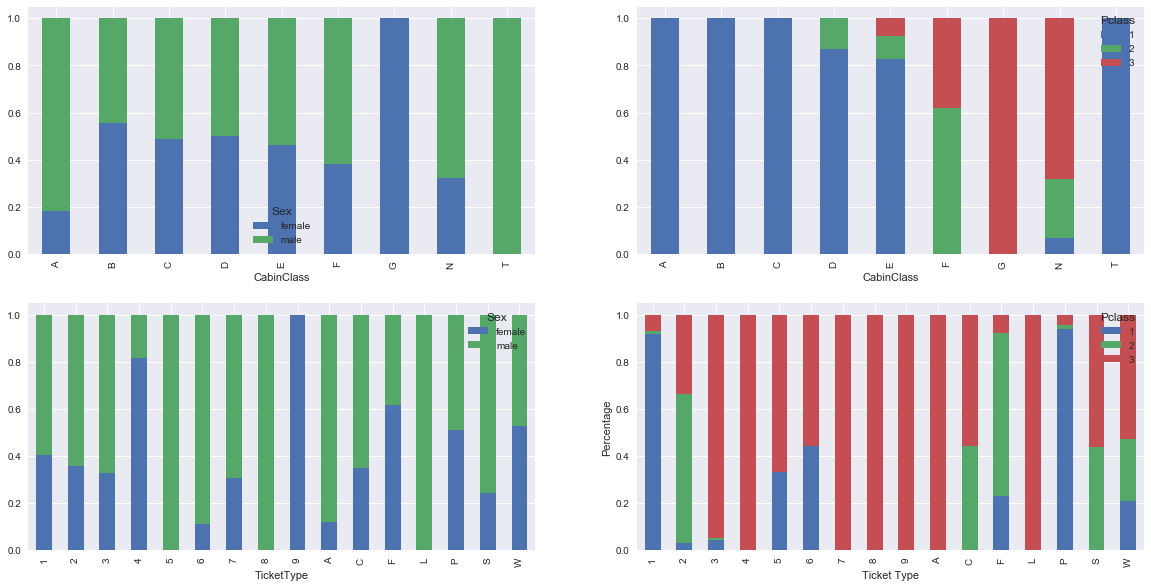

In [46]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223); ax4 = fig.add_subplot(224)

tab1 = pd.crosstab(combined['CabinClass'], 
                   combined['Sex'])
dummy1 = tab1.div(tab1.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax1)
dummy1 = plt.xlabel('Cabin Class')
dummy1 = plt.ylabel('Percentage')

tab2 = pd.crosstab(combined['CabinClass'], 
                   combined['Pclass'])
dummy2 = tab2.div(tab2.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax2)
dummy2 = plt.xlabel('Cabin Class')
dummy2 = plt.ylabel('Percentage')

tab3 = pd.crosstab(combined['TicketType'], 
                   combined['Sex'])
dummy3 = tab3.div(tab3.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax3)
dummy3 = plt.xlabel('Ticket Type')
dummy3 = plt.ylabel('Percentage')

tab4 = pd.crosstab(combined['TicketType'], 
                   combined['Pclass'])
dummy4 = tab4.div(tab4.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, ax = ax4)
dummy4 = plt.xlabel('Ticket Type')
dummy4 = plt.ylabel('Percentage')

From our initial plots, we observe that Cabin Classes B, C, D and E have much higher survival probabilities. Looking at the crosstab plots, it becomes clear that they were predominantly female and rich passengers, traits which yielded higher survival probabilities. To see this more closely, we can take a look at the 'A' cabins, which were predominantly Class 1 passengers. These cabins had questionably low survival rates as they were dominated by male inhabitants. Nontheless, let's try to encapsulate this set of information in our prediction model.

For ticket types, we observe that ticketholders holding ticket types P, 1, 2 and 9 had higher survival probabilities than other ticketholders. This trend is a little bit surprising, given that ticketholders of these ticket types were predominantly male (save for ticket type 9 and maybe P), although they were, on average, richer than the other ticketholders.

After this analysis, we understand that the TicketType and CabinClass features could be important in helping us predict whether a passenger survived. However, the selection criteria is key. Using the mean survival threshold of 0.4 for TicketType (which gives 5 groups in total) and 0.5 for Cabin Class, we attempt to filter key ticket types and cabin types which should, in theory, help us to predict the survival probability of the passengers.

In [47]:
tickettype_groupby = combined.groupby('TicketType').apply(np.mean)['Survived']

def good_ticket(ticket_type):
    if tickettype_groupby[ticket_type] > 0.4: return(1)
    else: return(0)
    
combined['GoodTicket'] = combined['TicketType'].apply(good_ticket)

In [48]:
cabinclass_groupby = combined.groupby('CabinClass').apply(np.mean)['Survived']

def good_cabin(cabinclass):
    if cabinclass_groupby[cabinclass] > 0.55: return(1)
    else: return(0)
    
combined['GoodCabinClass'] = combined['CabinClass'].apply(good_cabin)

### Imputing Missing Values

After our exploratory data analysis, we (finally) turn to impute the missing values in the dataset.

We first split our dataset into the training and testing dataset before the imputation.

In [49]:
train = combined[:len(df_train)]
test = combined[len(df_train):]

In [50]:
combined.isnull().sum()

Age                   263
Cabin                1014
Embarked                2
Fare                    1
Name                    0
Parch                   0
PassengerId             0
Pclass                  0
Sex                     0
SibSp                   0
Survived              418
Ticket                  0
FirstName               0
Title                   0
Child                   0
SharedTickets           0
GoodSharedTickets       0
Alone                   0
TicketType              0
CabinToStay             0
CabinClass              0
Family                  0
MiddleFam               0
AdjustedFare            1
CheapTickets            0
GoodTicket              0
GoodCabinClass          0
dtype: int64

Noting that the missing Cabin values shouldn't pose any major problems, we can (**finally**) focus our attention on imputing the missing Age and Embarkation values.

#### Imputing Missing Age

To impute the missing values for the column Age, we should rely on indicators which are correlated with Age to ensure that we are encapsulating all available information in our imputation. We plot a heatmap to identify these features.

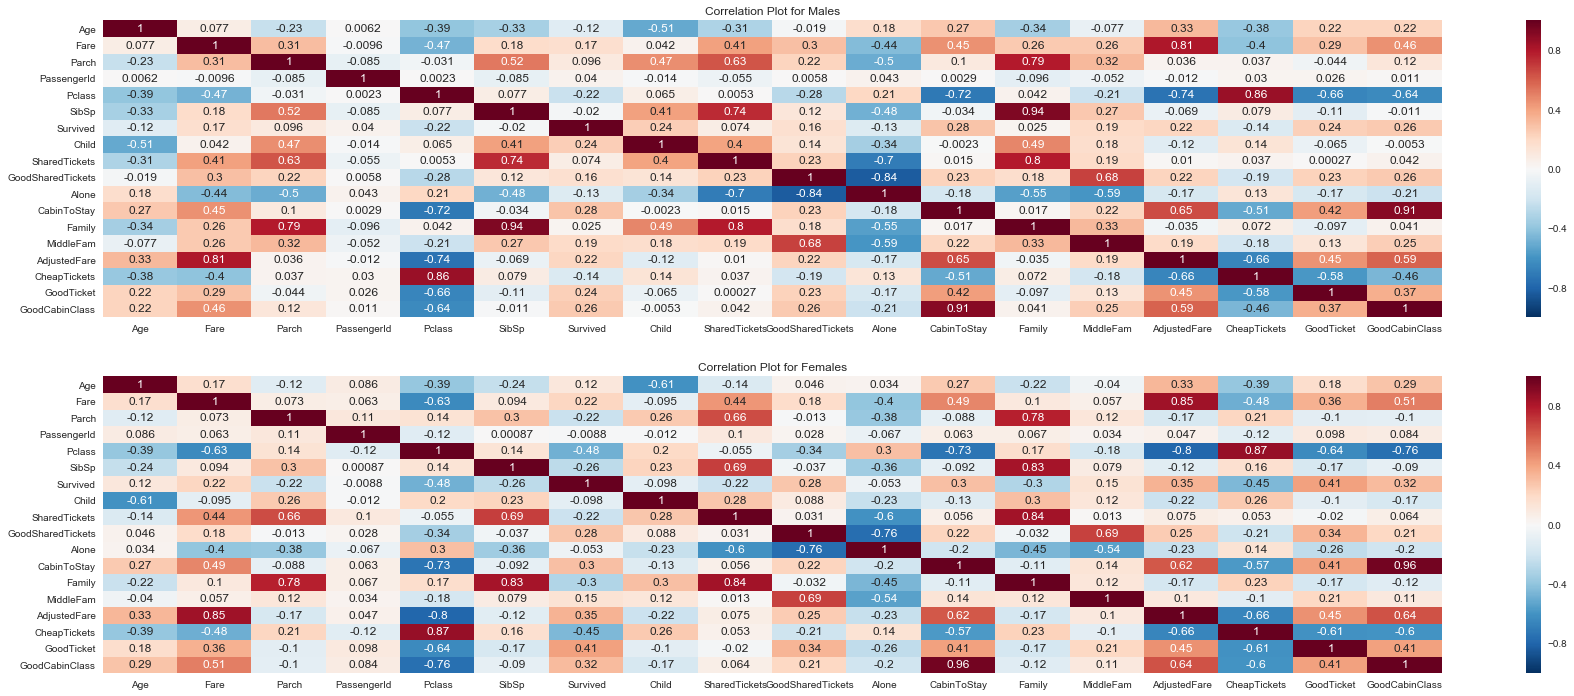

In [51]:
plt.figure(figsize=(30, 12))

plt.subplot(211)
train_male = train[train.Sex == 'male']
sns.heatmap(train_male.corr(), annot = True)
plt.title('Correlation Plot for Males')

plt.subplot(212)
train_female = train[train.Sex == 'female']
sns.heatmap(train_female.corr(), annot = True)
plt.title('Correlation Plot for Females')

We rely on the Title feature in our imputation.

In [52]:
age_prior = combined['Age'].copy()
groupby_impute_age = train.groupby(['Title']).apply(np.mean)[['Age']]
groupby_impute_age

,Age
Title,
Master,4.574167
Miss,21.860000
Mr,32.368090
Mrs,35.898148
Others,45.545455


We return the mean age based on the passenger's Title.

In [53]:
def return_age(age, title):
    if pd.notnull(age): return age
    else: return groupby_impute_age.ix[title]

return_age_vec = np.vectorize(return_age)
train['Age'] = return_age_vec(train['Age'], train['Title'])
test['Age'] = return_age_vec(test['Age'], test['Title'])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


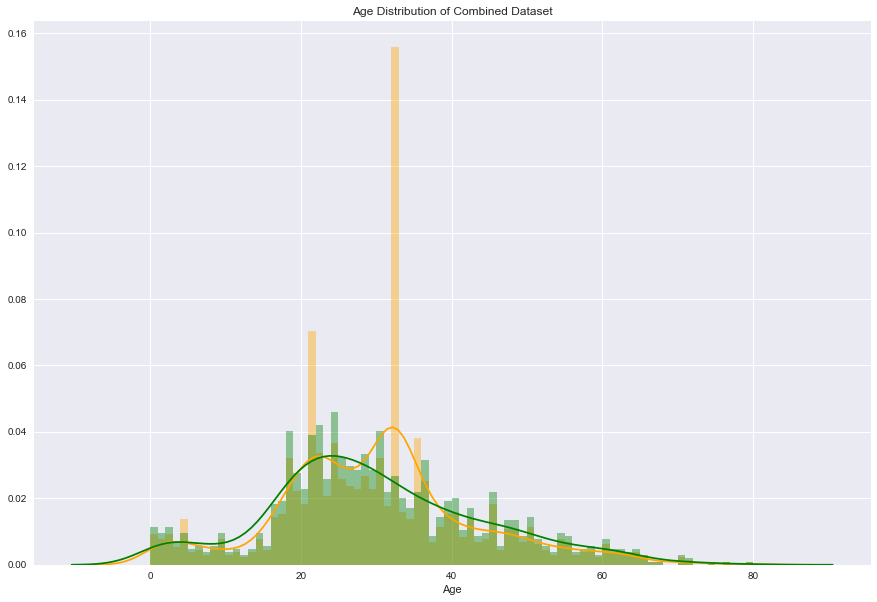

In [54]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 1, 1)
sns.distplot(combined['Age'], bins=range(0, 81, 1), color = 'orange')
sns.distplot(age_prior.dropna(), bins=range(0, 81, 1), color = 'green')
plt.title('Age Distribution of Combined Dataset')
plt.show()

After our imputation, there appears to be a large increase in the proportion of passengers aged 20 and 40, at the expense of other age groups.

We have 3 more missing values to fill - 2 missing embarkation points and 1 missing Fare. We can rely on the correlation plot to help us find the best variables to predict these features.

For point of embarkation, it turns out that previously, we have identified the Passenger Class featur.

For Fare, it turns out that Passenger Class and CabinToStay are good variables that we can rely on to predict how much the passenger paid.

In [55]:
train[train.Embarked.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Alone,TicketType,CabinToStay,CabinClass,Family,MiddleFam,AdjustedFare,CheapTickets,GoodTicket,GoodCabinClass
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,...,0,1,1,B,0,False,40.0,False,1,1
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,...,0,1,1,B,0,False,40.0,False,1,1


As it turns out, the 2 observations without an embarkation point were Class 1 Passengers, Females, had shared tickets and a Cabin to stay. Looking at our previous crosstab plots, they appeared to embark at point C.

In [56]:
train.ix[61, 'Embarked'] = 'C'
train.ix[829, 'Embarked'] = 'C'

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Lastly, we impute the missing fare. Let's take a quick look at the row.

In [57]:
test[test.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,...,Alone,TicketType,CabinToStay,CabinClass,Family,MiddleFam,AdjustedFare,CheapTickets,GoodTicket,GoodCabinClass
152,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,...,1,3,0,N,0,False,NaN,False,0,0


As a Class 3 Passenger with no Cabin to stay and the point of embarkation at 'S', let's find the mean fare of such a passenger.

In [58]:
print combined.groupby(['Pclass', 'CabinToStay', 
                        'Embarked']).apply(np.mean)['Fare'].ix[3].ix[0].ix['S']

14.5155051867


The average fare for such a passenger is 14.52. Let's impute it in, along with the other missing Fare features.

In [59]:
test.ix[152, 'Fare'] = combined.groupby(['Pclass', 'CabinToStay', 
                                         'Embarked']).apply(np.mean)['Fare'].ix[3].ix[0].ix['S']

In [60]:
# Adjusted Fare is the same as Fare since passenger is alone
test.ix[152, 'AdjustedFare'] = test.ix[152, 'Fare']
test.ix[152, 'CheapTickets'] = test.ix[152, 'AdjustedFare'] <= 0

### Feature Processing and Encoding

So far, we have yet to include/convert/encode some of our features. Let's include , convert and encode these features before we employ our machine learning algorithms to predict whether a particular passenger survived.

Let's take a look at the correlation plot after we have created these new features.

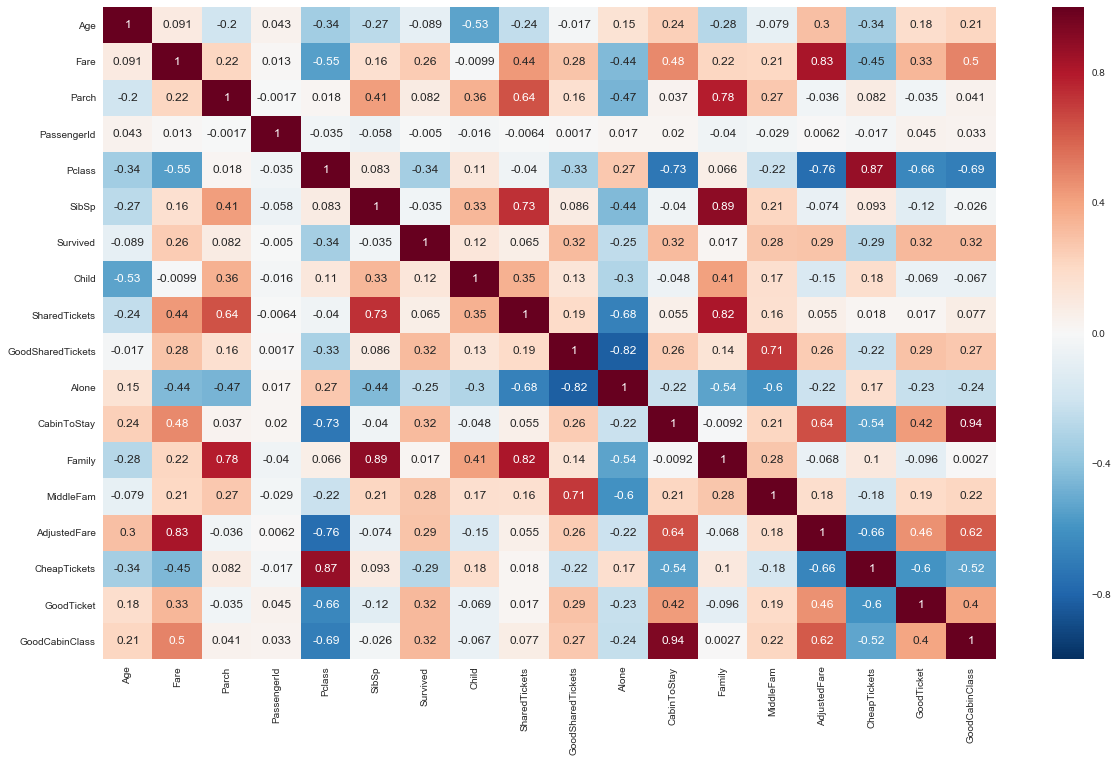

In [61]:
plt.figure(figsize=(20, 12))
sns.heatmap(combined[:len(df_train)].corr(), annot = True)

Now that we have converted our features to integer variables, let's proceed to encode our features!

In [62]:
from sklearn.preprocessing import LabelEncoder
encodeFeatures = ['Title', 'Pclass', 'Sex', 'Child', 'SharedTickets', 'Alone', 'Embarked',
                  'Family',  'GoodCabinClass', 'GoodTicket', 'CheapTickets', 'MiddleFam']

for i in encodeFeatures:
    combined[i] = combined[i].astype('category')
    
le = LabelEncoder()
combined_processed = combined[encodeFeatures].apply(le.fit_transform)

### Splitting into Subtraining, Subtesting and Testing datasets

As good data scientists, we split our training and testing datasets into Training, Cross-Validation and Testing data to evaluate our model. Given that we are dealing with a binary classification problem, we will employ the following techniques, along with hyperparameter tuning (aka GridSearch) with cross validation, to find the best prediction model:

1. Support Vector Machine (with linear kernel)
2. Random Forest Classifier
3. Gradient Boosting Classifier
4. K-Nearest Neighbors
5. Naive Bayes Classification
6. Neural Network

In [63]:
# Splitting Training Data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

X = combined_processed
y = combined['Survived']

X_test = X[len(train):].copy()
X_train = X[:len(train)].copy(); y_train = y[:len(train)].copy()

X_subtrain, X_subtest, y_subtrain, y_subtest = train_test_split(X_train, y_train, 
                                                                test_size = 0.2,
                                                                random_state = 42)

### Feature Selection and Model Fitting

We proceed to select key fetaures using Features Importances. Following which, we then fit our model using these features, and evaluate the models using the metric, Accuracy.

In [64]:
# Set Random State
random_state = 1212

#### Feature Importances

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

rf = RandomForestClassifier(n_estimators = 500, random_state = random_state).fit(X_subtrain, y_subtrain)
gb = GradientBoostingClassifier(n_estimators = 300, random_state = random_state).fit(X_subtrain, y_subtrain)

In [66]:
feature_importance = pd.DataFrame()
feature_importance['Features'] = X_subtrain.columns
feature_importance['RandomForest'] = rf.fit(X_subtrain, y_subtrain).feature_importances_
feature_importance['GBM'] = gb.fit(X_subtrain, y_subtrain).feature_importances_
feature_importance

,Features,RandomForest,GBM
0,Title,0.179418,0.097452
1,Pclass,0.081227,0.066670
2,Sex,0.269349,0.104168
3,Child,0.031666,0.064643
4,SharedTickets,0.105938,0.195828
5,Alone,0.026330,0.026845
6,Embarked,0.049226,0.094395
7,Family,0.071863,0.179772
8,GoodCabinClass,0.056832,0.039469
9,GoodTicket,0.053355,0.052427


#### Model Fitting

As it turns out, the features that we have selected are doing pretty well. None of them appears to be poor indicators of whether a passenger survived the tragedy. Let's use these features to fit our models.

We will attempt to fit 8 binary classification model, with hyperparameter tuning using GridSearch. Based on the cross validation score and the accuracy metric, we will choose the model with the highest cross-validation score, provided that it generalizes well to the test dataset. The models are:

* Logistic Regression
* Support Vector Machine
* Random Forest Classifier
* Gradient Boosting Classifier
* AdaBoost Classifier
* K-Nearest Neighbors
* Naive Bayesian Classifier
* Neural Network

In [67]:
# Model 1: Logistic Regression
from sklearn.linear_model import LogisticRegressionCV
logregr = LogisticRegressionCV(cv = 5, random_state = random_state).fit(X_subtrain, 
                                                                        y_subtrain)
logregr_score = cross_val_score(logregr, X_subtrain, y_subtrain, cv = 5).mean()
print logregr_score

0.806201849294


The Logistic Regression model scored 0.8062, a fairly decent score. What about the other models?

In [68]:
# Model 2: Support Vector Machine
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC(random_state = random_state, probability = True)
param_grid = {'kernel': ['linear', 'rbf'],
              'C': np.logspace(0, 2, 20)}
svm_clf = GridSearchCV(svm, param_grid, cv = 5).fit(X_subtrain, y_subtrain)

svm_score = cross_val_score(svm_clf, X_subtrain, y_subtrain, cv = 5).mean()
print svm_score

0.825871052332


As it turns out, the Support Vector Machine scored a total of 0.8259, a 1.5% improvement from the Logistic Regression model!

In [69]:
# Model 3: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 1000,
                            min_samples_split=10,
                            random_state = random_state)

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [4, 5, 6]}
rf_clf = GridSearchCV(rf, param_grid).fit(X_subtrain, y_subtrain)

rf_score = cross_val_score(rf_clf, X_subtrain, y_subtrain, cv = 5).mean()
print rf_score

0.834262660724


Our Random Forest Model was able to achieve a score 0.8343, the highest so far!

In [70]:
# Model 4: Gradient Boosting Model
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(loss = 'deviance', n_estimators = 1000, 
                                max_depth = 1, random_state = random_state)

param_grid = {'learning_rate': np.logspace(-2, 2, 10)}
gb_clf = GridSearchCV(gb, param_grid).fit(X_subtrain, y_subtrain)

gb_score = cross_val_score(gb_clf, X_subtrain, y_subtrain, cv = 5).mean()
print gb_score

0.82447259064


The Gradient Boosting Classifier scored an accuracy of 0.8245, just slightly lower than the Random Forest Model!

In [71]:
# Model 5: AdaBoost
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators = 500, random_state = random_state)

param_grid = {'learning_rate': np.logspace(-2, 2, 5),
              'algorithm': ['SAMME', 'SAMME.R']}
abc = GridSearchCV(abc, param_grid).fit(X_subtrain, y_subtrain)
abc_score = cross_val_score(abc, X_subtrain, y_subtrain, cv = 5).mean()
print abc_score

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:579: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)))
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in divide
  sample_weight /= sample_weight_sum
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:578: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:603: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: overflow encountered in exp
  (estimator_weight < 0)

0.820247098821


The AdaBoostClassifier scored 0.8202. What about the K-Nearest Neighbors model?

In [72]:
# Model 6: K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 10],
              'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(knn, param_grid).fit(X_subtrain, y_subtrain)

knn_score = cross_val_score(knn_clf, X_subtrain, y_subtrain, cv = 5).mean()
print knn_score

0.804743593236


The K-Nearest Neighbors model scored 0.8047, very close to the AdaBoostClassifier!

In [73]:
# Model 7: Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb = GridSearchCV(gnb, param_grid = {}, cv = 5).fit(X_subtrain, y_subtrain)

gnb_score = cross_val_score(gnb, X_subtrain, y_subtrain, cv = 5).mean()
print gnb_score

0.779499264096


The Naive Bayes Classifier scored 0.779; it is indeed as naive as it sounds.

In [74]:
# Model 8: Neural Network
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state = random_state)
param_grid = {'hidden_layer_sizes':[(30, 20, 20), (10, 30, 45), (10, 10), (10, 15, 20)],
              'solver': ['lbfgs', 'adam']}

nn_clf = GridSearchCV(clf, param_grid, cv = 5).fit(X_subtrain, y_subtrain)

nn_score = cross_val_score(nn_clf, X_subtrain, y_subtrain, cv = 5).mean()
print nn_score

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


0.818838648116


The Neural Network model scored an average of 0.8188 on the cross-validation datasets.

From the cross-validation scores of the 8 models, it does appear that the Random Forest model scored the highest amongst all the models. Let's see how well the Random Forest model generalizes to data not seen before i.e the testing set. 

If it turns out to generalize pretty well to the testing dataset, I think we have a winner here.

In [75]:
print 'Training Score - Logistic Regression: ', logregr.score(X_subtrain, y_subtrain)
print 'Testing Score - Logistic Regression: ', logregr.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - SVM: ', svm_clf.score(X_subtrain, y_subtrain)
print 'Testing Score - SVM: ',svm_clf.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - Random Forest Classifier: ', rf_clf.score(X_subtrain, y_subtrain)
print 'Testing Score - Random Forest: ', rf_clf.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - Gradient Boosting Classifier: ', gb_clf.score(X_subtrain, y_subtrain)
print 'Testing Score - Gradient Boosting Classifier: ', gb_clf.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - AdaBoost Classifier: ', abc.score(X_subtrain, y_subtrain)
print 'Testing Score - AdaBoost Classifier: ', abc.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - K-Nearest Neighbors Classifier: ', knn_clf.score(X_subtrain, y_subtrain)
print 'Testing Score - K-Nearest Neighbors Classifier: ', knn_clf.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - Gaussian Naive Bayesian Classifier: ', gnb.score(X_subtrain, y_subtrain)
print 'Testing Score - Gaussian Naive Bayesian Classifier: ', gnb.score(X_subtest, y_subtest)

print '\n'

print 'Training Score - MLP Classifier: ', nn_clf.score(X_subtrain, y_subtrain)
print 'Testing Score - MLP Classifier: ', nn_clf.score(X_subtest, y_subtest)

Training Score - Logistic Regression:  0.816011235955
Testing Score - Logistic Regression:  0.798882681564


Training Score - SVM:  0.848314606742
Testing Score - SVM:  0.826815642458


Training Score - Random Forest Classifier:  0.845505617978
Testing Score - Random Forest:  0.821229050279


Training Score - Gradient Boosting Classifier:  0.834269662921
Testing Score - Gradient Boosting Classifier:  0.826815642458


Training Score - AdaBoost Classifier:  0.831460674157
Testing Score - AdaBoost Classifier:  0.821229050279


Training Score - K-Nearest Neighbors Classifier:  0.86797752809
Testing Score - K-Nearest Neighbors Classifier:  0.782122905028


Training Score - Gaussian Naive Bayesian Classifier:  0.780898876404
Testing Score - Gaussian Naive Bayesian Classifier:  0.737430167598


Training Score - MLP Classifier:  0.865168539326
Testing Score - MLP Classifier:  0.810055865922


The Random Forest Classifier turns out to generalize pretty well to the testing dataset, scoring 
0.82123 on the testing data. As it turns out, the SVM and Gradient Boosting model did really too, on both the cross-validation and the testing dataset.

#### Ensembling

Before we use the Random Forest model to predict for the test set, we could also create an ensembling model using the predictions from the 8 models. In this case, we focus on using the predictions from the 3 models  - Random Forest, SVM and Gradient Boosting model as they have the highest cross validation score. Intuitively, this might make our model more robust. 

Before that, let's check for the correlation of the prediction on the subtesting datasets across the different models. If it turns out that the correlation between the different predictions is high, then we shouldn't expect our model to be much more robust than a standalone model. (**Why?**)

In [81]:
cv = pd.DataFrame()
cv['Logistic Regression'] = logregr.predict(X_subtrain)
cv['SVM'] = svm_clf.predict(X_subtrain)
cv['Random Forest'] = rf_clf.predict(X_subtrain)
cv['Gradient Boosting'] = gb_clf.predict(X_subtrain)
cv['ABC'] = abc.predict(X_subtrain)
cv['K-Nearest Neighbors'] = knn_clf.predict(X_subtrain)
cv['Gaussian Naive Bayes'] = gnb.predict(X_subtrain)
cv['MLP Classifier'] = nn_clf.predict(X_subtrain)

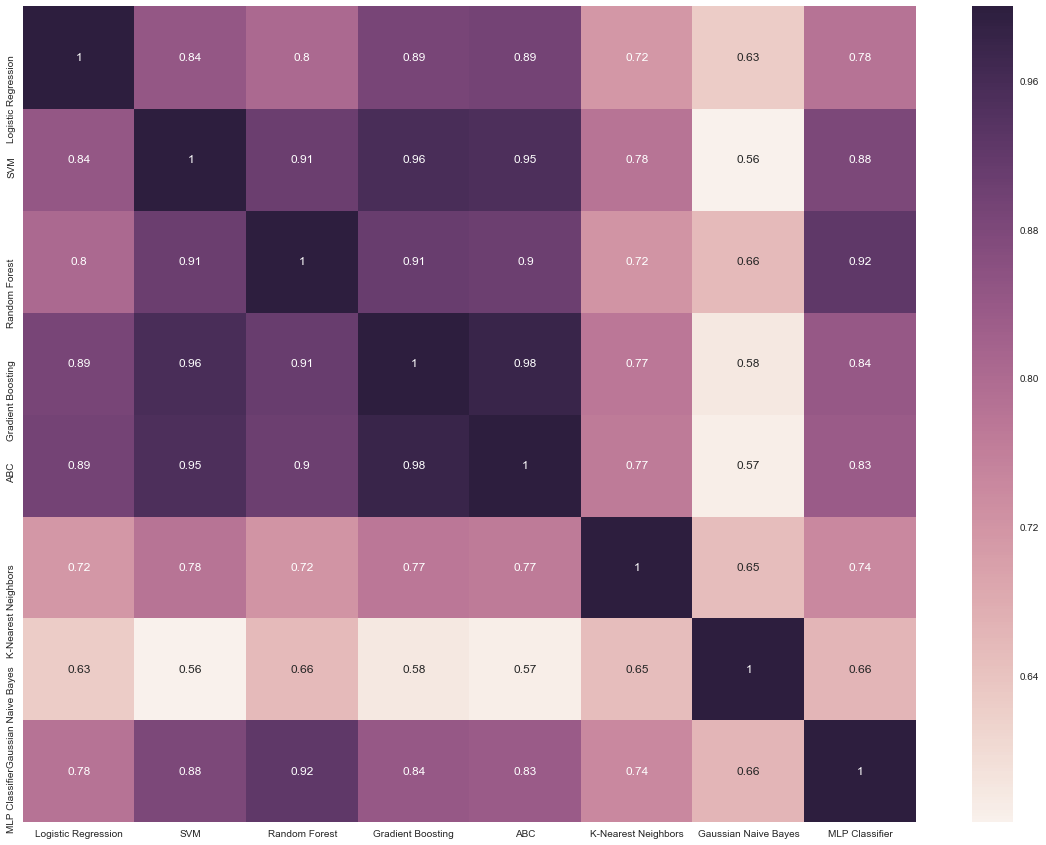

In [82]:
plt.figure(figsize=(20, 15))
sns.heatmap(cv.corr(), annot = True)

As it turns out, the predictions from the 3 models are all strongly correlated with one another (correlation are all larger than 0.9). This is a red flag. Nontheless, we can still create an ensemble model, and see how well it generalizes to the testing dataset.

In [85]:
cv_score = pd.DataFrame(index=['Max Cross-Validation Score', 'Testing Score'])
cv_score['SVM'] = [svm_score, svm_clf.score(X_subtest, y_subtest)]
cv_score['Random Forest'] = [rf_score, rf_clf.score(X_subtest, y_subtest)]
cv_score['Gradient Boosting'] = [gb_score, gb_clf.score(X_subtest, y_subtest)]

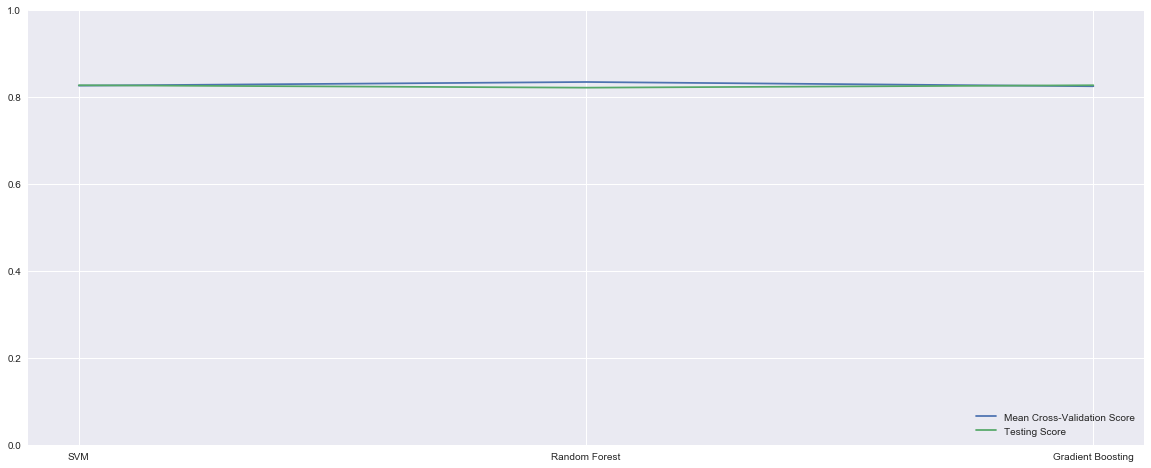

In [87]:
no_of_models = range(1, len(cv_score.columns) + 1)

plt.figure(figsize = (20, 8))

plt.plot(no_of_models, cv_score.T['Max Cross-Validation Score'], 
         no_of_models, cv_score.T['Testing Score'])

plt.legend(['Mean Cross-Validation Score', 'Testing Score'], loc='lower right')

plt.xticks(no_of_models, cv_score.T.index)
plt.ylim([0, 1])
plt.show()

From the graph, it really does appear that the models are not severely overfitting (Random Forest is **slightly** overfitting). The training score on the cross-validation scores are similar to that of the testing score. Let's use an ensemble of the 3 models to predict for the testing data set.

Let's create a new function to take into account the prediction of the 4 models.

In [88]:
cv_pred = pd.DataFrame()
cv_pred['SVM'] = svm_clf.predict(X_subtrain)
cv_pred['Random Forest'] = rf_clf.predict(X_subtrain)
cv_pred['Gradient Boosting'] = gb_clf.predict(X_subtrain)

In [89]:
from sklearn.metrics import accuracy_score

def pred(x):
    if x >= 2: return 1
    else: return 0
    
print accuracy_score(y_subtrain, map(pred, cv_pred.sum(axis = 1)))

0.842696629213


Using our ensemble method, we scored 0.8427 on our training set. What about our testing set?

In [92]:
cv_pred = pd.DataFrame()
cv_pred['SVM'] = svm_clf.predict(X_subtest)
cv_pred['Random Forest'] = rf_clf.predict(X_subtest)
cv_pred['Gradient Boosting'] = gb_clf.predict(X_subtest)

In [93]:
from sklearn.metrics import accuracy_score
ensemble = map(pred, cv_pred.sum(axis = 1))
print accuracy_score(y_subtest, cv_pred['Random Forest'])

0.821229050279


Using a simple ensemble model, we were able to achieve a testing score of 0.82123, similar to that of the Random Forest model. It appears that the ensemble did not help to improve our cross-validation score significantly. Furthermore, we did not conduct cross-validation on the ensemble model. Due to these factors, let's use the Random Forest model to predict for the actual testing dataset.

In [94]:
test_pred = pd.DataFrame()
test_pred['SVM'] = svm_clf.predict(X_test)
test_pred['Random Forest'] = rf_clf.predict(X_test)
test_pred['Gradient Boosting'] = gb_clf.predict(X_test)
test_pred['ABC'] = abc.predict(X_test)
test_pred['MLP'] = nn_clf.predict(X_test)

ensemble = map(pred, test_pred.sum(axis = 1))

As a final sense-check, let's check to ensure that the mean survival rate that we have obtained is not too far away from the average survival rate in the training datasets.

In [95]:
print 'Mean Survival Rate for Training Dataset: ', np.mean(df_train['Survived'])
print 'Mean Survival Rate for Testing Dataset: ', np.mean(test_pred['Random Forest'])

Mean Survival Rate for Training Dataset:  0.383838383838
Mean Survival Rate for Testing Dataset:  0.33971291866


The training dataset had a mean survival rate of 0.384 while our prediction yields a mean survival rate of 0.340 on the testing set. These figures do not look too different (a 5% difference is still fine, I think), and we can submit our predictions to Kaggle.

In [96]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = map(int, test_pred['Random Forest'])
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [97]:
submission.to_csv('submission.csv', index = False)

Now, let's submit it to Kaggle!

[Afternote: Our submission earned us a score of 0.80383, placing us at the top 15 percentile of the Kaggle competition. This was a marked improvement from my previous score, which only came in at 0.78947.]